In [1]:
import os
from typing import Literal, Any, Optional, Union
import sys
from operator import add, attrgetter

import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes
import matplotlib.figure
import matplotlib.text
import matplotlib.backend_bases
import matplotlib.offsetbox
import matplotlib.collections
import matplotlib.artist
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from umap import UMAP
import requests
from tqdm.notebook import tqdm
from joblib import Parallel, delayed


In [2]:
print(sys.version)


3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:37:07) [Clang 15.0.7 ]


In [3]:
print(f"matplotlib version: {matplotlib.__version__}")


matplotlib version: 3.8.0


In [4]:
# need ipympl installed
# interactive plots
%matplotlib widget


In [5]:
# ダウンロードするファイルのURL
url = "http://datachemeng.wp.xdomain.jp/wp-content/uploads/2017/04/logSdataset1290_2d.sdf"

# ダウンロード先のディレクトリ
download_dir = "data"

# ローカルに保存するファイルのパス
local_file_path = os.path.join(download_dir, "logSdataset1290_2d.sdf")

# ファイルが既に存在するかチェック
if not os.path.exists(local_file_path):
    # ファイルをダウンロード
    response = requests.get(url)
    if response.status_code == 200:
        # ダウンロード成功時にローカルに保存
        os.makedirs(download_dir, exist_ok=True)
        with open(local_file_path, "wb") as file:
            file.write(response.content)
        print("ファイルをダウンロードしました。")
    else:
        print("ファイルのダウンロードに失敗しました。")
else:
    print("ファイルは既にローカルに存在します。ダウンロードをスキップします。")


ファイルは既にローカルに存在します。ダウンロードをスキップします。


In [6]:
# SDFファイルのパス
sdf_file_path = "data/logSdataset1290_2d.sdf"

# SDFファイルをDataFrameに読み込む
df = PandasTools.LoadSDF(sdf_file_path)

# DataFrameを表示
df.head()


,CAS_Number,logS,ID,ROMol,CA_Number
0,60-35-5,1.58,CC(N)=O,<rdkit.Chem.rdchem.Mol object at 0x14471fb50>,NaN
1,NaN,1.34,CNN,<rdkit.Chem.rdchem.Mol object at 0x1447c0040>,60-34-4
2,NaN,1.22,CC(O)=O,<rdkit.Chem.rdchem.Mol object at 0x1447c00b0>,64-19-7
3,NaN,1.15,C1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x1447c0120>,123-75-1
4,NaN,1.12,NC([NH]O)=O,<rdkit.Chem.rdchem.Mol object at 0x1447c0190>,127-07-1


In [7]:
mols = df["ROMol"].tolist()
smiles = list(map(Chem.MolToSmiles, mols))


In [8]:
# create all features in rdkit.Chem.Descriptors


X = pd.DataFrame.from_dict(
    {
        desc_name: map(desc_func, mols)
        for desc_name, desc_func in tqdm(Descriptors.descList)
    }
    # Parallel(n_jobs=-1)(delayed(lambda func: map(func, mols))(desc_func) for desc_name, desc_func in tqdm(Descriptors.descList)),
)
X.head()


  0%|          | 0/211 [00:00<?, ?it/s]

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.222222,9.222222,0.333333,-0.333333,0.401031,6.25,59.068,54.028,59.037114,24,...,0,0,0,0,0,0,0,0,0,0
1,4.597222,4.597222,1.652778,1.652778,0.273315,6.00,46.073,40.025,46.053098,20,...,0,0,0,0,0,0,0,0,0,0
2,9.000000,9.000000,0.833333,-0.833333,0.429883,6.25,60.052,56.020,60.021129,24,...,0,0,0,0,0,0,0,0,0,0
3,3.222222,3.222222,1.250000,1.250000,0.434794,24.00,71.123,62.051,71.073499,30,...,0,0,0,0,0,0,0,0,0,0
4,9.229167,9.229167,0.939815,-0.939815,0.256644,6.60,76.055,72.023,76.027277,30,...,0,0,0,0,0,0,0,0,0,1


In [9]:
X.isnull().any().any()


False

In [10]:
X = X.loc[:, X.std(axis=0) > 0]


In [11]:
umap = UMAP(
    n_neighbors=15,
    n_components=2,
    metric="mahalanobis",
    random_state=334,
    metric_kwds=dict(VI=np.linalg.inv(np.cov(X, rowvar=False))),
    n_jobs=1,
    # metric="euclidean",
    # n_jobs=-1,
)
X_umap = umap.fit_transform(X)


\# TODO

- 物性値の表示
- <s>画像サイズの変更 (スクロール→上下キー)</s>
- <s>zorderの調整 (とにかく最大のzorderに+1するで実現できる？)</s>
- <s>クラス化して、グローバル変数を排除する</s>
- <s>htmlに書き出す</s>
- アクティブな点でctrl+cするとSMILESをコピー、アクティブなannotationでctrl+cすると画像をコピー
- widthをautoにする。(ax.get_xlimなどから自動で設定できるようにする。)

In [12]:
def is_plotted(ax: Optional[matplotlib.axes.Axes] = None) -> bool:
    """Check if an axes has been plotted on.

    Parameters
    ----------
    ax : matplotlib.axes.Axes | None
        The axes to check. If None, the current axes will be used.
        optional, by default None

    Returns
    -------
    bool
        True if the axes has been plotted on, False otherwise.
    """
    ax = plt.gca() if ax is None else ax
    return any(
        len(getattr(ax, _key))
        for _key in dir(ax)
        if isinstance(getattr(ax, _key), matplotlib.axes.Axes.ArtistList)
    )


In [13]:
class OffsetImageWithAnnotation(matplotlib.offsetbox.VPacker):
    def __init__(
        self,
        arr: ArrayLike,
        zoom: float = 0.3,
        text: Optional[str] = None,
    ) -> None:
        children = [
            matplotlib.offsetbox.OffsetImage(arr, zoom=zoom),
            matplotlib.offsetbox.TextArea(text if text else ""),
        ]
        super().__init__(children=children, align="left")

    def get_children(
        self,
    ) -> tuple[
        matplotlib.offsetbox.OffsetImage, matplotlib.offsetbox.TextArea
    ]:
        return tuple(super().get_children())

    def set_data(
        self,
        arr: ArrayLike,
    ) -> None:
        self.get_children()[0].set_data(arr)

    def set_text(
        self,
        text: str,
    ) -> None:
        self.get_children()[1].set_text(text)

    def get_zoom(
        self,
    ) -> float:
        return self.get_children()[0].get_zoom()

    def set_zoom(
        self,
        zoom: float,
    ) -> None:
        zoom_before = self.get_zoom()

        text_object: matplotlib.text.Text = self.get_children()[
            1
        ].get_children()[0]
        text_object.set_fontsize(
            zoom / zoom_before * text_object.get_fontsize()
        )
        self.get_children()[0].set_zoom(zoom)


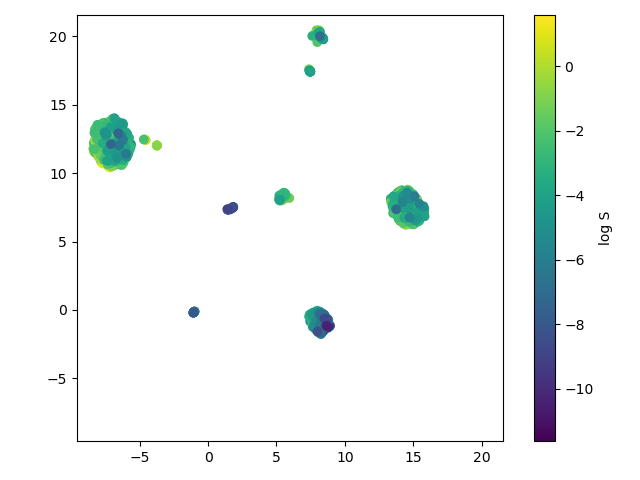

TypeError: float() argument must be a string or a real number, not 'NoneType'

In [14]:
class InteractiveChemicalViewer:
    def __init__(
        self,
        ax: Optional[matplotlib.axes.Axes] = None,
        width: Union[int, float] = 25,
        scale: float = 0.3,
    ) -> None:
        self.width = width
        self.scale = scale

        # CONSTANTS
        self.LINEWIDTH_INACTIVE = 0.5
        self.LINEWIDTH_ACTIVE = 1

        # ax = plt.gca() if ax is None else ax
        # if is_plotted(ax=ax):
        #     self.ax = ax
        # else:
        #     _, ax = plt.subplots(facecolor="white")
        #     self.ax = ax
        # self.fig = self.ax.figure
        if ax is None:
            self.ax = plt.gca()
        else:
            self.ax = ax
        self.fig = self.ax.figure

        self.lst_annotations_visible: list[
            matplotlib.offsetbox.AnnotationBbox
        ] = []
        self.annotation_active: Optional[
            matplotlib.offsetbox.AnnotationBbox
        ] = None
        self.annotation_dragging: Optional[
            matplotlib.offsetbox.AnnotationBbox
        ] = None

        self.zorder_max = 3

        # hover時に表示するannotation
        # self.imagebox_hover = matplotlib.offsetbox.OffsetImage(
        #     np.zeros((2, 2)), zoom=self.scale
        # )  # 適当な画像
        # self.imagebox_hover.image.axes = self.ax
        self.imagebox_hover = OffsetImageWithAnnotation(
            np.zeros((2, 2)),
            zoom=self.scale,
            text=None,
        )
        self.imagebox_hover.axes = self.ax
        self.annotation_hover = matplotlib.offsetbox.AnnotationBbox(
            self.imagebox_hover,
            xy=(add(*self.ax.get_xlim()) / 2, add(*self.ax.get_ylim()) / 2),
            xybox=(self.width, self.width),
            xycoords="data",
            boxcoords="data",
            pad=0.5,
            arrowprops=dict(arrowstyle="->"),
            zorder=self.zorder_max,
        )
        # 隠しておく
        self.annotation_hover.patch.set_linewidth(self.LINEWIDTH_INACTIVE)
        self.annotation_hover.set_visible(False)
        self.ax.add_artist(self.annotation_hover)

        # 登録
        self.fig.canvas.mpl_connect("motion_notify_event", self.hover)
        self.fig.canvas.mpl_connect("button_press_event", self.on_click)
        self.fig.canvas.mpl_connect("button_release_event", self.on_release)
        self.fig.canvas.mpl_connect("motion_notify_event", self.on_motion)

        self.fig.canvas.mpl_connect("key_press_event", self.resize_annotation)

        self.fig.tight_layout()
        self.fig.canvas.draw_idle()

    # HACK: molsをOptionalにできるようにしたい。
    def scatter(
        self,
        x: ArrayLike,
        y: ArrayLike,
        mols: list[Chem.rdchem.Mol],
        texts: Optional[list[str]] = None,
        **kwargs,
    ) -> matplotlib.collections.PathCollection:
        if texts is None:
            texts = [""] * len(mols)
        assert (
            len(mols) == len(x) == len(y) == len(texts)
        ), "lengths of mols, x, and y must be the same"
        self.texts = texts
        self.scatter_object = self.ax.scatter(x, y, **kwargs)
        return self.scatter_object

    def hover(
        self,
        event: matplotlib.backend_bases.MouseEvent,
    ) -> None:
        visibility = self.annotation_hover.get_visible()
        # マウスが乗っているのが当該axならば
        # かつ、annotationのどれにもマウスが乗っていないならば
        if event.inaxes == self.ax:
            # scatter_objectのcontainsメソッドで、マウスが乗っているかどうかを判定
            contains, details = self.scatter_object.contains(event)
            # マウスが乗っている場合
            if (
                contains
                and self.annotation_active is None
                and not any(
                    _annotation.contains(event)[0]
                    for _annotation in self.lst_annotations_visible
                )
            ):
                details: dict[
                    Literal["ind"], np.ndarray[Any, np.dtype[np.int32]]
                ]
                # annotationを更新する作業
                # details["ind"]でマウスが乗っているscatterのindexが取得できる
                # scatterのindexが1次元のnp.ndarrayで返ってくる。（複数が重なっていることもあるため）
                _index_scatter: int = details["ind"][0]

                # 当該点の座標を取得して、位置を更新
                self.annotation_hover.xy = self.scatter_object.get_offsets()[
                    _index_scatter
                ]

                # 画像を更新
                self.imagebox_hover.set_data(
                    Draw.MolToImage(mols[_index_scatter])
                )
                # HACK: テキストを指定できるようにする
                self.imagebox_hover.set_text(self.texts[_index_scatter])

                # 見えるようにして
                self.annotation_hover.set_visible(True)
                # 一番手前にして
                if self.annotation_hover.zorder < self.zorder_max:
                    self.zorder_max += 1
                    self.annotation_hover.set(zorder=self.zorder_max)
                # 再描画
                self.fig.canvas.draw_idle()
            # マウスが乗っていない場合
            else:
                # 今annotationが見えているならば
                if visibility:
                    # annotationを見えなくする
                    self.annotation_hover.set_visible(False)
                    # 再描画
                    self.fig.canvas.draw_idle()

    def on_click(self, event: matplotlib.backend_bases.MouseEvent) -> None:
        """クリック時の挙動"""
        # マウスが乗っているのが当該axならば
        if event.inaxes == self.ax:
            # すべてのvisibleなannotationについて
            # for _annotation in self.lst_annotations_visible:
            # zorderの上からそのannotationを触っているのか判定する
            for _annotation in sorted(
                self.lst_annotations_visible, key=attrgetter("zorder")
            )[::-1]:
                contains, _ = _annotation.contains(event)
                # そのannotationにマウスが乗っているならば
                if contains:
                    # 今アクティブなものを非アクティブにする
                    if (
                        type(self.annotation_active)
                        is matplotlib.offsetbox.AnnotationBbox
                    ):
                        self.annotation_active.patch.set_linewidth(
                            self.LINEWIDTH_INACTIVE
                        )
                    # アクティブにする
                    self.annotation_active = _annotation
                    self.annotation_dragging = _annotation
                    # アクティブであることを強調するため、枠線を太くする
                    self.annotation_active.patch.set_linewidth(
                        self.LINEWIDTH_ACTIVE
                    )

                    # 一番手前に持ってくる
                    if _annotation.zorder < self.zorder_max:
                        self.zorder_max += 1
                        _annotation.set(zorder=self.zorder_max)

                    # ダブルクリックしたら削除
                    if event.dblclick:
                        self.lst_annotations_visible.remove(_annotation)
                        _annotation.remove()
                        self.annotation_active = None
                        self.annotation_dragging = None
                    # 次のannotationは見ずに終了
                    break
            # annotationにマウスが乗っていないならば
            else:
                # アクティブなannotationがあるならばそれはとりあえずそれは非アクティブ化する
                if (
                    type(self.annotation_active)
                    is matplotlib.offsetbox.AnnotationBbox
                ):
                    self.annotation_active.patch.set_linewidth(
                        self.LINEWIDTH_INACTIVE
                    )

                # scatter_objectにマウスが乗っているかどうかを判定
                contains, details = self.scatter_object.contains(event)
                # マウスが乗っている場合
                if contains and self.annotation_active is None:
                    index: int = details["ind"][0]

                    # HACK: annotationつきのoffsetboxを作成する
                    # _imageboxを作成して
                    # _imagebox = matplotlib.offsetbox.OffsetImage(
                    #     Draw.MolToImage(mols[index]), zoom=self.scale
                    # )
                    # _imagebox.image.axes = self.ax
                    _imagebox = OffsetImageWithAnnotation(
                        Draw.MolToImage(mols[index]),
                        zoom=self.scale,
                        text=self.texts[index],  # HACK: テキストを指定できるようにする
                    )
                    _imagebox.axes = self.ax

                    # annotationを作成
                    self.zorder_max += 1
                    _annotation = matplotlib.offsetbox.AnnotationBbox(
                        _imagebox,
                        xy=self.scatter_object.get_offsets()[index],
                        xybox=(self.width, self.width),
                        xycoords="data",
                        boxcoords="data",
                        # boxcoords="offset points",
                        pad=0.5,
                        arrowprops=dict(arrowstyle="->", facecolor="black"),
                        zorder=self.zorder_max,
                    )
                    _annotation.set_visible(True)
                    self.ax.add_artist(_annotation)

                    # アクティブ化
                    self.annotation_active = _annotation
                    self.annotation_active.patch.set_linewidth(
                        self.LINEWIDTH_ACTIVE
                    )
                    # 移動可能にするために保存
                    self.annotation_dragging = _annotation
                    self.lst_annotations_visible.append(_annotation)
                # 点とannotationのいずれにもマウスが乗っていない場合
                else:
                    # アクティブなannotationがあるならば非アクティブ化する
                    self.annotation_active = None
            self.fig.canvas.draw_idle()

    def on_motion(self, event: matplotlib.backend_bases.MouseEvent) -> None:
        if (
            type(self.annotation_dragging)
            is matplotlib.offsetbox.AnnotationBbox
        ):
            self.annotation_dragging.xybox = (
                event.xdata,
                event.ydata,
            )
            # 再描画
            self.ax.figure.canvas.draw_idle()

    def on_release(self, event: matplotlib.backend_bases.MouseEvent) -> None:
        self.annotation_dragging = None

    def resize_annotation(
        self, event: matplotlib.backend_bases.KeyEvent
    ) -> None:
        """上矢印で拡大・下矢印で縮小

        もし'active'なannotationがあれば、それだけを拡大する。
        もし'active'なものがないならば全部を拡大する。
        """
        if event.inaxes == self.ax:
            for _annotation in self.lst_annotations_visible:
                contains, _ = _annotation.contains(event)
                if contains:
                    # 上キー/下キーでoffsetboxを拡大縮小できる
                    # offset_image: matplotlib.offsetbox.OffsetImage = (
                    #     _annotation.offsetbox
                    # )
                    offset_image: OffsetImageWithAnnotation = (
                        _annotation.offsetbox
                    )
                    if event.key == "up":
                        offset_image.set_zoom(offset_image.get_zoom() * 1.1)
                    elif event.key == "down":
                        offset_image.set_zoom(offset_image.get_zoom() / 1.1)
                    # 再描画
                    self.fig.canvas.draw_idle()
                    break
            else:
                for _annotation in self.lst_annotations_visible:
                    offset_image: matplotlib.offsetbox.OffsetImage = (
                        _annotation.offsetbox
                    )
                    if event.key == "up":
                        offset_image.set_zoom(offset_image.get_zoom() * 1.1)
                    elif event.key == "down":
                        offset_image.set_zoom(offset_image.get_zoom() / 1.1)
                    # 再描画
                    self.fig.canvas.draw_idle()

    # def on_click_point(self, event: matplotlib.backend_bases.MouseEvent) -> None:
    #     if event.inaxes != self.ax:
    #         return

    #     if event.button == 1:
    #         self.add_annotation(event)


viewer = InteractiveChemicalViewer(width=1)
mappable = viewer.scatter(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    mols=mols,
    # texts=[f"{i}\n{_smi}" for i, _smi in enumerate(smiles)],
    texts="logS: " + df["logS"].astype(str),
    c=df["logS"].astype(float),
)

_xlim = viewer.ax.get_xlim()
_ylim = viewer.ax.get_ylim()
_lim = min(min(_xlim), min(_ylim)), max(max(_xlim), max(_ylim))
viewer.ax.set_xlim(_lim)
viewer.ax.set_ylim(_lim)
viewer.ax.set_aspect("equal")
viewer.fig.colorbar(mappable, ax=viewer.ax, label="log S")
viewer.fig.tight_layout()
# viewer.scatter(mols, X_umap[:, 0], X_umap[:, 1])
# plt.show()
